In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

/Users/ankurkothari/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
(features, labels), (X_test_orig, Y_test_orig) = cifar10.load_data()
features = features/255 - 0.5
labels = labels.flatten()

test_images = X_test_orig/255 - 0.5
test_labels = Y_test_orig.flatten()


Using TensorFlow backend.


In [4]:
#for stability
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

In [5]:
print('designing model')
# Training Parameters
learning_rate = 0.005
n_epochs = 2500 # changed to 2500 for a LB score of ~2.69


# Network Parameters
num_input = 32*32 #size of the images
num_classes = 10 # Binary
dropout = 0.4 # Dropout, probability to keep units

designing model


In [6]:
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")


with tf.variable_scope('ConvNet'):
    # Convolutional Layer #1
    dropout_rate = 0.3

    training = tf.placeholder_with_default(False, shape=(), name='training')
    X_drop = tf.layers.dropout(X, dropout_rate, training=training)
    conv1 = tf.layers.conv2d(X_drop, filters=32,
                         kernel_size=5,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

    conv2 = tf.layers.conv2d(conv1, filters=64, 
                         kernel_size=3,
                         strides=2, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
    pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")
    conv4 = tf.layers.conv2d(pool3, filters=128, 
                         kernel_size=4,
                         strides=3, padding="SAME",
                         activation=tf.nn.relu, name="conv4")

    pool5 = tf.nn.max_pool(conv4,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 1, 1, 1],
                       padding="VALID")

    pool5_flat = tf.contrib.layers.flatten(pool5)

    fullyconn1 = tf.layers.dense(pool5_flat, 128,
                             activation=tf.nn.relu, name="fc1")

    fullyconn2 = tf.layers.dense(fullyconn1, 64,
                             activation=tf.nn.relu, name="fc2")
    logits = tf.layers.dense(fullyconn2, 10, name="output")

In [7]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [8]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [9]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [10]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [11]:
def get_next_batch(features, labels, train_size, batch_index, batch_size):
    training_images = features[:train_size,:,:]
    training_labels = labels[:train_size]
    
    start_index = batch_index * batch_size
    end_index = start_index + batch_size

    return features[start_index:end_index,:,:], labels[start_index:end_index]

In [149]:
print('training model\n')
n_epochs = 50
batch_size = 128

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         batch_index = 0
        # Add this in when we want to run the training on all batches in CIFAR-10
        batch_index = 0

        train_size = int(len(features))

        for iteration in range(train_size // batch_size):
            X_batch, y_batch = get_next_batch(features, 
                                                                        labels, 
                                                                        train_size, 
                                                                        batch_index,
                                                                        batch_size)
            batch_index += 1

            sess.run([training_op, loss], feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch, training: True})
        acc_test = accuracy.eval(feed_dict={X: test_images, y: test_labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        print ("Train Accuracy:", round(acc_train, 2)*100,"%",  end="\t")
        print ("Test Accuracy:", round(acc_test, 2)*100,"%", end="\n")
    #    save_path = saver.save(sess, "./cifar_model")
    save_path = saver.save(sess, "model/cnn.ckpt")

training model

0 Train accuracy: 0.601562 Test accuracy: 0.5273
Train Accuracy: 60.0000023842 %	Test Accuracy: 52.999997139 %
1 Train accuracy: 0.6875 Test accuracy: 0.6085
Train Accuracy: 68.9999997616 %	Test Accuracy: 61.0000014305 %
2 Train accuracy: 0.71875 Test accuracy: 0.6345
Train Accuracy: 72.000002861 %	Test Accuracy: 62.9999995232 %
3 Train accuracy: 0.726562 Test accuracy: 0.6454
Train Accuracy: 73.0000019073 %	Test Accuracy: 64.9999976158 %
4 Train accuracy: 0.796875 Test accuracy: 0.6654
Train Accuracy: 80.0000011921 %	Test Accuracy: 67.0000016689 %
5 Train accuracy: 0.8125 Test accuracy: 0.6636
Train Accuracy: 81.0000002384 %	Test Accuracy: 66.0000026226 %
6 Train accuracy: 0.820312 Test accuracy: 0.6611
Train Accuracy: 81.9999992847 %	Test Accuracy: 66.0000026226 %
7 Train accuracy: 0.867188 Test accuracy: 0.6691
Train Accuracy: 87.0000004768 %	Test Accuracy: 67.0000016689 %
8 Train accuracy: 0.898438 Test accuracy: 0.6794
Train Accuracy: 89.9999976158 %	Test Accuracy:

In [12]:

print('making predictions\n')
#make external predictions on the test_dat
with tf.Session() as sess:
    saver.restore(sess, "model/cnn.ckpt") # or better, use save_path
    import cv2
    img = cv2.imread("horse1.png")
    img = cv2.resize(img, (32, 32))
    resized_image_flatten = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print("Your algorithm predicts: y = " + classnames[logits.eval(feed_dict={X: resized_image_flatten}).argmax()])




making predictions

INFO:tensorflow:Restoring parameters from model/cnn.ckpt
Your algorithm predicts: y = cat


making predictions

INFO:tensorflow:Restoring parameters from model/cnn.ckpt


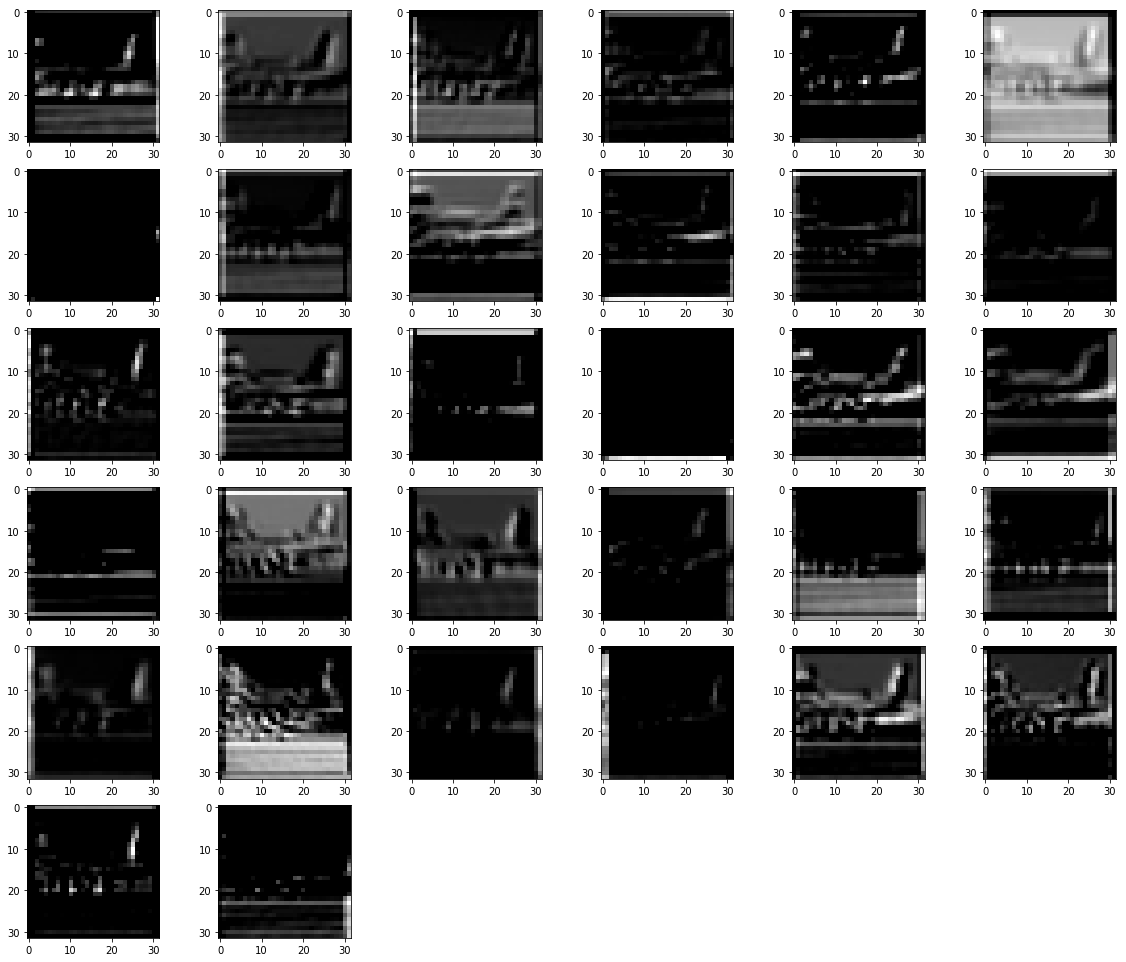

In [14]:
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import math
import tensorflow as tf
print('making predictions\n')
#make external predictions on the test_dat
with tf.Session() as sess:
    saver.restore(sess, "model/cnn.ckpt") # or better, use save_path
    import cv2
    img = cv2.imread("airplane1.png")
    img = cv2.resize(img, (32, 32))
    resized_image_flatten = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    units = conv1.eval(feed_dict={X: resized_image_flatten})
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        plt.savefig("CONV_rslt.png")